In [1]:
from __future__ import print_function

import plotly.express as px

from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import pandas as pd
import geopandas as gpd

import datetime
import pickle

import matplotlib.pyplot as plt
import ndpretty

import data_prep

In [2]:
ndpretty.default()

In [4]:
data = data_prep.load_beijing_data()


Loaded air quality data from 87 devices. No weather data for ['fangshan', 'miyun', 'yanqing', 'badaling', 'miyunshuiku', 'yufa', 'liulihe', '1042A', '1043A', '1044A', '1045A', '1046A', '1047A', '1048A', '1049A', '1050A', '1067A', '1068A', '1069A', '1070A', '1074A', '1075A', '1076A']


# Analysis

## Sensors

In [97]:
def show_sensor_map(meta):
    meta_plot = meta.copy()
    meta_plot['color'] = 1
    meta_plot.loc[meta_plot['city'] == 'Beijing', 'color'] = 0

    fig = px.scatter_mapbox(meta_plot,
                            lat=meta_plot.geometry.y,
                            lon=meta_plot.geometry.x,
                            color='color',
                            color_continuous_scale=px.colors.sequential.Blackbody,
                            hover_name='city',
                            hover_data=["device_id", 'device_name'],
                            width=1000, height=700)

    fig.update_layout(
        title='Devices',
        autosize=True,
        hovermode='closest',
        showlegend=False,
        mapbox=dict(
            bearing=0,
            center=dict(
                lat=39,
                lon=117
            ),
            pitch=0,
            zoom=5,
            style='stamen-terrain'
        ),
    )

    fig.show()

show_sensor_map(data.metadata)

## Measurements

### Individual measurements

In [6]:
days_list = pd.date_range(data.measurements["time"].min(), data.measurements["time"].max(), freq='D')
days_list_formatted = [(date.strftime(' %d-%m-%y '), date) for date in days_list]

ld1 = data.events[0]
start = ld1.start - datetime.timedelta(days=14)
end = ld1.end + datetime.timedelta(days=14)

date_slider = widgets.SelectionRangeSlider(
    options=days_list_formatted,
    index=(0, len(days_list_formatted) - 1),
    value=(start, end),
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

In [7]:
devices = data.metadata['device_id']
descriptions = data.metadata['device_id'] + " (" + data.metadata['city'] + ")"
dic = dict(zip(descriptions, devices))

In [8]:
def plot_data(data, devices, date_range, feature, events=[], device_id_mapping=None):
    plt.figure(figsize=(10,5))

    # plot events
    for event in events:
        plt.axvspan(event.start, event.end, color=event.color, alpha=0.1, label=event.name)

    # plot measurements
    (start, end) = date_range
    for device in devices:
        if device_id_mapping is not None:
            device_id = device_id_mapping[device]
        else:
            device_id = device
        y = data[(data['device_id'] == device_id) & (data['time'] >= start) & (data['time'] < end)]
        plt.plot(y['time'], y[feature], label=device)

    plt.tight_layout()

    plt.title(feature)
    plt.legend(loc='upper left')
    axes = plt.gca()
    axes.set_xlim([start,end])

    plt.show()

device_widget = widgets.SelectMultiple(
    options=dic.keys(),
    rows=15,
    description='Devices',
    disabled=False
)

feature_widget = widgets.Dropdown(
    options=data.air_features,
    value='pm25',
    description='Feature:'
)

interact_manual(plot_data, data=fixed(data.measurements), devices=device_widget, date_range=date_slider, feature=feature_widget, events=fixed(data.events), device_id_mapping=fixed(dic))

interactive(children=(SelectMultiple(description='Devices', options=('dongsi (Beijing)', 'tiantan (Beijing)', …

<function __main__.plot_data(data, devices, date_range, feature, events=[], device_id_mapping=None)>

### City means

In [9]:
city_means = data.measurements_joined.groupby(by=['city', 'time']).mean().reset_index()
city_means = city_means.rename(columns={'city': 'device_id'})

In [10]:
city_widget = widgets.SelectMultiple(
    options=list(city_means['device_id'].unique()),
    rows=15,
    description='Devices',
    disabled=False
)

interact_manual(plot_data, data=fixed(city_means), devices=city_widget, date_range=date_slider, feature=feature_widget, events=fixed(data.events), device_id_mapping=fixed(None))

interactive(children=(SelectMultiple(description='Devices', options=('Baoding', 'Beijing', 'Cangzhou', 'Chengd…

<function __main__.plot_data(data, devices, date_range, feature, events=[], device_id_mapping=None)>

In [13]:
def show_map(measurements, time, feature):
    x = measurements[measurements['time'] == time]
    
    # x = x.merge(meta, on=['device_id', 'city'])
    x = gpd.GeoDataFrame(x)

    x["size"] = 10

    fig = px.scatter_mapbox(x,
                            lat=x.geometry.y,
                            lon=x.geometry.x,
                            hover_name='city',
                            hover_data=["device_id", 'device_name'],
                            color=feature,
                            size='size',
                            color_continuous_scale=px.colors.sequential.matter,
                            width=1000, height=700)

    fig.update_layout(
        title=f'Measurements on {time}',
        autosize=True,
        hovermode='closest',
        showlegend=False,
        mapbox=dict(
            bearing=0,
            center=dict(
                lat=39,
                lon=117
            ),
            pitch=0,
            zoom=5,
            style='stamen-terrain' # 'stamen-terrain'
        ),
    )

    fig.show()
    # plt.show()s

# interact(show_map, time=date_slider)
show_map(data.measurements_joined, '2020-04-15 00:00:00', 'pm25')

### Check for missing data

In [14]:
# select only every third hour (that's how they use it in PM2.5-GNN) - use %2==2, since we have most data for (2:00, 5:00, 8:00, etc.)
filtered_city_means = city_means[city_means['time'].dt.hour % 6 == 2]
del filtered_city_means['co']
del filtered_city_means['no2']
del filtered_city_means['o3']
del filtered_city_means['pm10']
del filtered_city_means['so2']
# filtered_city_means
missing_city_means = filtered_city_means[filtered_city_means.isnull().any(axis=1)]

There's quite a few entries, where we don't have a single measurement per city:

In [15]:
missing_city_means[missing_city_means['device_id'] == 'Beijing']

,device_id,time,pm25,temperature,humidity,windSpeed,windBearing,precipIntensity,lon,lat
45459,Beijing,2016-03-08 02:00:00,NaN,0.187037,0.220370,7.625556,42.259259,0.000000,116.405514,39.986543
46449,Beijing,2016-04-18 08:00:00,NaN,13.851235,0.311852,6.720000,0.000000,0.000000,116.405514,39.986543
46473,Beijing,2016-04-19 08:00:00,NaN,10.847942,0.627037,6.720000,120.000000,0.000000,116.405514,39.986543
48915,Beijing,2016-07-30 02:00:00,NaN,27.862346,0.844074,6.720000,110.000000,0.000000,116.405514,39.986543
49149,Beijing,2016-08-08 20:00:00,NaN,26.843621,0.662222,4.480000,161.000000,0.000000,116.405514,39.986543
...,...,...,...,...,...,...,...,...,...,...
86283,Beijing,2020-11-03 02:00:00,NaN,3.484362,0.182963,3.548148,276.851852,0.000000,116.405514,39.986543
86289,Beijing,2020-11-03 08:00:00,NaN,2.942798,0.256296,3.371111,288.370370,0.000000,116.405514,39.986543
86841,Beijing,2020-11-26 08:00:00,NaN,-1.250206,0.608889,2.531481,75.296296,0.000000,116.405514,39.986543
87237,Beijing,2020-12-12 20:00:00,NaN,-0.088477,0.678519,6.358148,261.074074,0.007615,116.405514,39.986543


### Missing data

In [88]:
def analyse_missing_data(relevant):
    relevant_missing = relevant[relevant.isnull().any(axis=1)]
    
    print(f"Missing of relevant data: {len(relevant_missing) / len(relevant) * 100}%")

    missing_by_device = relevant_missing.groupby('device_id').count()
    plt.figure(figsize=(15,5))
    plt.bar(missing_by_device.index, missing_by_device['time'])
    plt.xticks(missing_by_device.index, rotation='vertical')
    plt.show()

    missing_by_time = relevant_missing.groupby(relevant_missing['time']).count()
    plt.figure(figsize=(15,5))
    plt.plot(missing_by_time.index, missing_by_time['device_id'])
    plt.show()

    return relevant_missing

Missing of relevant data: 27.283567307285068%


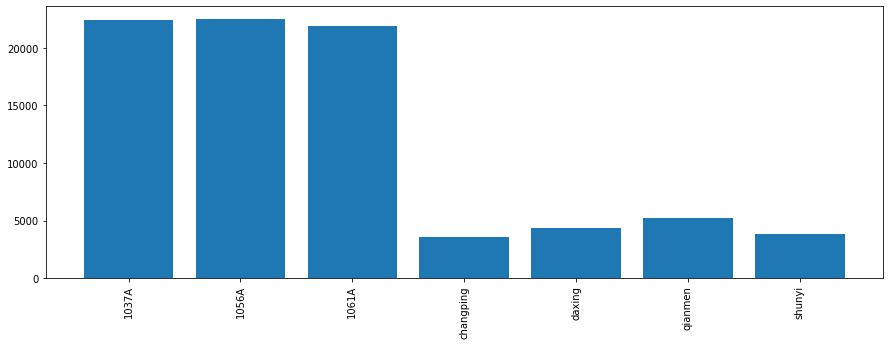

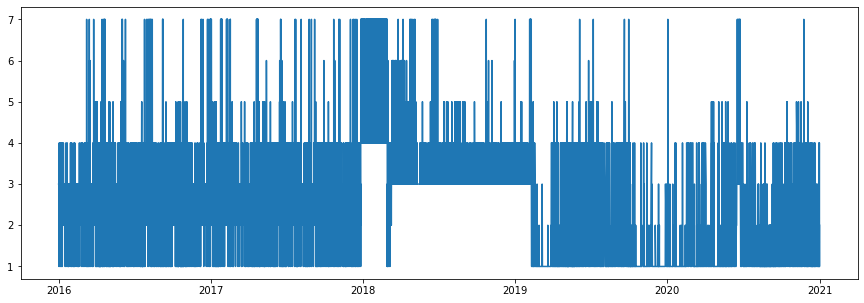

,device_id,pm25,time,temperature,humidity,windSpeed,windBearing,precipIntensity
108,daxing,NaN,2016-01-05 12:00:00,0.016667,0.21,11.19,330.0,0.0
109,daxing,NaN,2016-01-05 13:00:00,0.016667,0.21,8.96,311.0,0.0
212,daxing,NaN,2016-01-09 20:00:00,-3.983333,0.54,0.00,0.0,0.0
274,daxing,NaN,2016-01-12 10:00:00,-5.994444,0.32,13.42,20.0,0.0
685,daxing,NaN,2016-01-29 13:00:00,-2.061111,0.36,4.82,166.0,0.0
...,...,...,...,...,...,...,...,...
43695,1061A,NaN,2020-12-25 15:00:00,-2.161111,0.36,4.41,309.0,0.0
43696,1061A,NaN,2020-12-25 16:00:00,-2.888889,0.37,2.71,347.0,0.0
43700,1061A,NaN,2020-12-25 20:00:00,-8.288889,0.52,2.81,33.0,0.0
43845,1061A,NaN,2020-12-31 21:00:00,-14.983333,0.31,5.85,318.0,0.0


In [99]:
rel_fields = ['device_id', 'pm25', 'time', 'temperature', 'humidity', 'windSpeed', 'windBearing', 'precipIntensity'
            ]
rel_devices = [ 'qianmen', 'changping', 'daxing', 'shunyi', # Beijing
                '1056A', # Baoding
                # '1069A', # Langfang
                '1061A', # Zhangjiakou
                '1037A', # Tangshan
                ]

relevant = data.measurements[rel_fields]
relevant = relevant[relevant['device_id'].isin(rel_devices)]

relevant_missing = analyse_missing_data(relevant)
relevant_missing

In [98]:
show_sensor_map(data.metadata)

Super surrounding
- Baoding (south-west)
- Langfang (south-east)
- Zhangjiakou (north)
- Tangshan (east)

In the area:
- Shijiazhuang (south-west)

Beijing:
- qianmen (center)
- changping (north)
- daxing (south)
- shunyi (north-east)